In [1]:
import umap
import json
import base64
from io import BytesIO
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import umap

In [2]:
# Load the dataset
data = np.load('norm-o-95.npy')
data = data.reshape(10046, 64, 64)
data_tensor = torch.Tensor(data).unsqueeze(1)  # Add channel dimension
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [3]:
# Constants
img_size = 64  # Image size (64x64)
img_channels =1 #1 for greyscale
latent_dim = 128  # Latent dimension for Generator and Encoder

In [4]:
# Define the Generator with CNN
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, img_size):
        super(Generator, self).__init__()
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [5]:
# Define the Discriminator
class DiscriminatorWithAutoencoder(nn.Module):
    def __init__(self, img_channels, img_size):
        super(DiscriminatorWithAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        ds_size = img_size // 2 ** 4
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, img_channels, 4, stride=2, padding=1)
        )

        self.fc = nn.Sequential(
            nn.Linear(512 * ds_size ** 2, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        encoded = self.encoder(img)
        encoded_flat = encoded.view(encoded.size(0), -1)
        validity = self.fc(encoded_flat)
        decoded = self.decoder(encoded)
        return validity, encoded, decoded

In [6]:
# Define the Encoder using CNN
class Encoder(nn.Module):
    def __init__(self, img_channels, img_size, latent_dim):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        ds_size = img_size // 2 ** 4
        self.fc = nn.Linear(512 * ds_size ** 2, latent_dim)

    def forward(self, img):
        encoded = self.encoder(img)
        encoded_flat = encoded.view(encoded.size(0), -1)
        latent = self.fc(encoded_flat)
        return latent

In [7]:
# Load pre-trained models
gen = Generator(latent_dim, img_channels, img_size).cuda()
dis = DiscriminatorWithAutoencoder(img_channels, img_size).cuda()
gen.load_state_dict(torch.load('generatorwithCNN-o.pth'))
dis.load_state_dict(torch.load('discriminatorwithCNN-o.pth'))

encoder = Encoder(img_channels, img_size, latent_dim).cuda()
encoder.load_state_dict(torch.load('trained_encoder_cnn-o.pth'))

<All keys matched successfully>

In [8]:
gen.eval()
dis.eval()
encoder.eval()

criterion = nn.MSELoss()

In [13]:
# Assuming encoder, gen, dis, and criterion are already defined and moved to GPU if available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mse_losses = []
image_losses = []
feature_vectors = []
indices = []
total_losses = []

for idx, original_img in enumerate(data):
    original_img = torch.Tensor(original_img).unsqueeze(0).unsqueeze(0).to(device)  
    
    # Pass the original image through the Encoder to get the latent representation
    latent_representation = encoder(original_img)

    # Pass the latent representation through the Generator
    generated_img = gen(latent_representation)

    # Get feature vectors from the Discriminator
    _, original_features, _ = dis(original_img)
    _, generated_features, _ = dis(generated_img)

    # Calculate the feature loss between the original and generated feature vectors
    feature_loss = criterion(original_features.view(original_features.size(0), -1), generated_features.view(generated_features.size(0), -1)).item()
    mse_losses.append(feature_loss)

    # Calculate the loss between the original and generated images
    image_loss = criterion(original_img, generated_img).item()
    image_losses.append(image_loss)

    # Use the latent representation as the feature vector
    feature_vectors.append(latent_representation.detach().cpu().numpy())
    indices.append(idx)

    # Calculate total loss
    total_loss = feature_loss + image_loss
    total_losses.append(total_loss)

# Convert list of numpy arrays to a single numpy array
feature_vectors = np.concatenate(feature_vectors, axis=0)

# Ensure feature_vectors contains the correct data
print(f"Sample feature vector: {feature_vectors[0]}")

# Serialize feature vectors to JSON strings
feature_vectors_str = [json.dumps(vec.tolist()) for vec in feature_vectors]

# Create a DataFrame with the collected information
data_dict = {
    'Index': indices,
    'Feature Loss': mse_losses,
    'Image Loss': image_losses,
    'Total Loss': total_losses,
    'Feature Vectors': feature_vectors_str
}
df = pd.DataFrame(data_dict)

print(df.head())

# Deserialize feature vectors from JSON strings
feature_vectors = np.array([np.array(json.loads(fv)) for fv in df['Feature Vectors']])

# Ensure feature_vectors has the correct shape
print(f"Deserialized feature vectors shape: {feature_vectors.shape}")

# Initialize UMAP
umap_model = umap.UMAP(n_components=3)

# Fit and transform the feature vectors using UMAP
umap_result = umap_model.fit_transform(feature_vectors)

# Debug: Print the shape of the UMAP result to ensure the transformation was successful
print(f"UMAP result shape: {umap_result.shape}")

# Optionally, print some of the UMAP results for inspection
print(umap_result[:5])

# Add UMAP results to the DataFrame
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2', 'UMAP3'])

# Combine the original DataFrame with the UMAP results
df = pd.concat([df, umap_df], axis=1)

print(df.head())


Sample feature vector: [ 0.5607928   0.20729887 -0.43411106 -1.1838865   0.29549867 -1.6791289
  0.16690555 -0.12082249  0.91213995  0.68566704 -0.6087904   0.42711657
 -1.3498265   0.7048128  -1.0034798   0.36566246 -0.36467063 -0.46916232
  0.16324678 -1.005196   -0.21237151 -0.9142514  -0.43366945 -0.33801576
  0.54463947  0.77545565  0.63572216 -0.9503916  -0.26649287 -0.11571714
  0.64369446  0.60265136  0.3741935  -0.11886826 -1.0983232  -0.11407529
 -0.80185056  0.11206333  0.18735686  0.72106856  0.4875244   0.6234404
  0.25798604  0.69484055  0.20686291 -0.54391766  0.87581646 -0.13583001
 -0.74878454  0.28802872  0.1472683   0.3863819   0.01028827 -0.36929366
 -0.46622148 -1.0493507  -0.9532856   0.5038438  -0.7094269   0.15483838
  0.05289498  0.6333374  -1.2986147  -0.94742686 -0.73553413 -0.55656254
  0.47871932 -0.14339094  0.8356045   0.01030917 -0.13657668  0.953435
  0.39083594 -0.35537672 -1.3670142  -0.52580285 -0.63749814  0.06144885
  1.1123583  -1.2485297  -0.0769

   Index  Feature Loss  Image Loss  Total Loss  \
0      0      0.006017    0.001018    0.007034   
1      1      0.039868    0.011328    0.051196   
2      2      0.001260    0.000188    0.001448   
3      3      0.026455    0.001890    0.028345   
4      4      0.024515    0.007129    0.031644   

                                     Feature Vectors     UMAP1     UMAP2  \
0  [0.5607928037643433, 0.2072988748550415, -0.43...  9.672794  1.397721   
1  [1.3332520723342896, 1.3279993534088135, 1.541...  4.378425  2.556413   
2  [0.5689720511436462, 0.24377107620239258, -0.2...  9.229001  2.875037   
3  [1.5116114616394043, 0.1212877482175827, 0.169...  8.686544  3.310343   
4  [1.6188886165618896, 1.4631267786026, 0.464481...  4.467738  1.778254   

      UMAP3     UMAP1     UMAP2     UMAP3  
0  4.209498  9.672794  1.397721  4.209498  
1  2.618668  4.378425  2.556413  2.618668  
2  5.500550  9.229001  2.875037  5.500550  
3  2.829558  8.686544  3.310343  2.829558  
4  2.069766  4.467738 

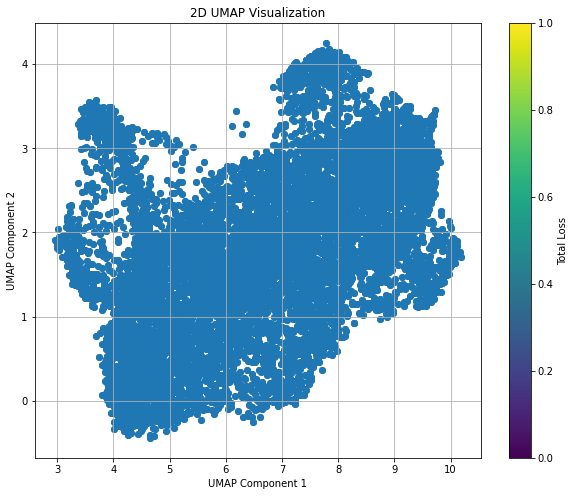

In [14]:
# Add UMAP results to the DataFrame
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2', 'UMAP3'])

# Combine the original DataFrame with the UMAP results
df = pd.concat([df, umap_df], axis=1)

print(df.head())

# Visualize the 2D UMAP
plt.figure(figsize=(10, 8))
plt.scatter(df['UMAP1'], df['UMAP2'])
plt.colorbar(label='Total Loss')
plt.title('2D UMAP Visualization')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

In [16]:
# Create JSON blobs
data_to_save = []

for iter_index in tqdm(range(len(df))):
    json_blob = {}
    
    umap1, umap2, umap3 = umap_result[iter_index, :3]
    json_blob['id'] = int(df.iloc[iter_index]['Index'])

    metadata = {}
    metadata['feature_loss'] = float(df.iloc[iter_index]['Feature Loss'])
    metadata['image_loss'] = float(df.iloc[iter_index]['Image Loss'])
    metadata['total_loss'] = float(df.iloc[iter_index]['Total Loss'])
    metadata['umap1'] = float(umap1)
    metadata['umap2'] = float(umap2)
    metadata['umap3'] = float(umap3)

    with BytesIO() as outfile:
        plt.imsave(outfile, data[json_blob['id']], cmap='gray', format='jpeg')
        outfile.seek(0)
        img_encoded = base64.b64encode(outfile.read())

    json_blob['metadata'] = metadata
    json_blob['url'] = [f"data:image/jpeg;base64,{img_encoded.decode('utf-8')}"]
    data_to_save.append(json_blob)

# Save the data_to_save list as a JSON file
with open('umap_data_new_Original.json', 'w') as json_file:
    json.dump(data_to_save, json_file, indent=4)

print("Data saved to umap_data_new_anoter_original.json")

100%|███████████████████████████████████████████████████████████████████████████| 10046/10046 [00:12<00:00, 793.48it/s]


Data saved to umap_data_new_anoter_original.json
